# Feed forward neural network for the MNIST dataset


In [27]:
from __future__ import absolute_import, division, print_function 

import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils
import tensorflow as tf
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## The MNIST dataset
The 70,000 images-label pairs are split into a 
* 55,000 images training set, 
* 5,000 images validation set and 
* 10,000 images test set.

The images are 28x28 pixels, where each pixel represents the light intensity normalised value between 0-1 (0=black, 1=white).
The number of features is therefore 28x28=784.

In [28]:
# Load data (download if you haven't already)
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32' # rescale images to `[0, 1]`
                                      )

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Information on dataset
----------------------
Training size:	 55000
Test size	 10000
Validation size	 5000

Data summaries
Image shape		 784
Image type		 <class 'numpy.float32'>
Image min/max value	 0.0 / 1.0
Label shape		 10
Label type		 <class 'numpy.float64'>


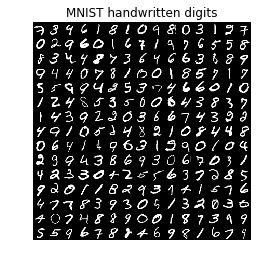

In [29]:
## Print dataset statistics and visualize
print("""Information on dataset
----------------------""")
print("Training size:\t", mnist_data.train.num_examples)
print("Test size\t", mnist_data.test.num_examples)
print("Validation size\t", mnist_data.validation.num_examples)

num_features = mnist_data.train.images[0].shape[0]
num_classes = mnist_data.train.labels[0].shape[0]

print('\nData summaries')
print("Image shape\t\t", num_features)
print("Image type\t\t", type(mnist_data.train.images[0][0]))
print("Image min/max value\t", np.min(mnist_data.train.images), '/', np.max(mnist_data.train.images))
print("Label shape\t\t", num_classes)
print("Label type\t\t", type(mnist_data.train.labels[0][0]))


## Plot a few MNIST examples
img_to_show = 15
idx = 0
canvas = np.zeros((28*img_to_show, img_to_show*28))
for i in range(img_to_show):
    for j in range(img_to_show):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = mnist_data.train.images[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(4,4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()


## Creating the graph



In [30]:
## Build the network
tf.reset_default_graph()

## Define placeholders
x_pl = tf.placeholder(tf.float32, [None, num_features], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
# Depending on your implementation you might need to cast y_pl differently
y_pl = tf.cast(y_pl, tf.float32)

## Define the model

### YOUR CODE HERE ###
weight_initializer = tf.truncated_normal_initializer(stddev=0.1)

n_nodes_hl1 = 500

with tf.variable_scope('layer1'): 
    W_1 = tf.get_variable('W', [num_features, n_nodes_hl1],
                          initializer=weight_initializer)
    b_1 = tf.get_variable('b', [n_nodes_hl1],
                          initializer=tf.constant_initializer(0.0))
    with tf.variable_scope('output'):
        
        l_1 = tf.matmul(x_pl, W_1) + b_1
        l_1 = tf.nn.relu(l_1)
        
with tf.variable_scope('layer2'): 
    W_2 = tf.get_variable('W', [n_nodes_hl1, num_classes],
                          initializer=weight_initializer)
    b_2 = tf.get_variable('b', [num_classes],
                          initializer=tf.constant_initializer(0.0))
    with tf.variable_scope('output'):
        l_2 = tf.matmul(l_1, W_2) + b_2

y_ = tf.nn.softmax(l_2)

### Defining training operations


In [31]:
# 1) Define cross entropy loss
with tf.variable_scope('loss'):
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y_), reduction_indices=[1])
    cross_entropy = tf.reduce_mean(cross_entropy)
    
# 2) Define the training op
with tf.variable_scope('trainOP'):
    # Defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)

    # Computing our gradients
    grads_and_vars = optimizer.compute_gradients(cross_entropy)

    # Applying the gradients
    train_op = optimizer.apply_gradients(grads_and_vars)
    
# 3) Define accuracy op
with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y_, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#### Testing the training loop

In [33]:
#Test the forward pass
batch_size = 32

# Get a mini-batch
x, y = mnist_data.train.next_batch(batch_size)

# Restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    sess.run(tf.global_variables_initializer())
    
    ### YOUR CODE HERE ###
    feed_dict = {x_pl:x, y_pl:y}
    fetches_train = [y_,train_op, cross_entropy, accuracy]
    res = sess.run(fetches=fetches_train, feed_dict=feed_dict)
    y_pred = res[0]
        
assert y_pred.shape == y.shape, "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

# Build the training loop.
We train the network by calculating the gradient w.r.t the cost function and update the parameters in direction of the negative gradient. 

In [53]:
max_epochs = 5

# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)

x_val = mnist_data.validation.images
y_val = mnist_data.validation.labels
feed_dict_validation = {x_pl: x_val, y_pl: y_val}
fetches_validation = [cross_entropy, accuracy]

img_to_show = 10
x_plot, y_plot = mnist_data.validation.next_batch(img_to_show**2)

train_cost, val_cost, train_acc, val_acc = [],[],[],[]
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:    
    try:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(max_epochs):
            epoch_cost, epoch_acc = 0, 0
            # 1) Run the train op
            # 2) Compute train_cost, val_cost, train_acc, val_acc
            for _ in range(int(mnist_data.train.num_examples/batch_size)):
                x_tr, y_tr = mnist_data.train.next_batch(batch_size)
                feed_dict_train = {x_pl: x_tr, y_pl: y_tr}
                fetches_train = [train_op, cross_entropy, accuracy]
                _, c, a = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
                epoch_cost += c
                epoch_acc += a
            
            ## Validation set
            epoch_val_cost, epoch_val_acc = sess.run(fetches=fetches_validation, feed_dict=feed_dict_validation)
                
            train_cost += [epoch_cost/int(mnist_data.train.num_examples/batch_size)]
            train_acc += [epoch_acc/int(mnist_data.train.num_examples/batch_size)]
            val_cost += [epoch_val_cost]
            val_acc += [epoch_val_acc]
            
            # 3) Print training summaries
            if epoch % 1 == 0:
                print("Epoch %i, Train Cost: %0.3f\t  Train acc: %0.3f\t Val Cost: %0.3f\t Val acc: %0.3f" \
                      %(epoch, train_cost[-1], train_acc[-1] ,val_cost[-1],val_acc[-1]))
                
        pred = sess.run(y_,feed_dict={x_pl:x_plot})
        
    except KeyboardInterrupt:
        print('KeyboardInterrupt')

print('Done')


Epoch 0, Train Cost: 0.211	  Train acc: 0.938	 Val Cost: 0.105	 Val acc: 0.968
Epoch 1, Train Cost: 0.084	  Train acc: 0.975	 Val Cost: 0.085	 Val acc: 0.974
Epoch 2, Train Cost: 0.053	  Train acc: 0.983	 Val Cost: 0.073	 Val acc: 0.978
Epoch 3, Train Cost: 0.036	  Train acc: 0.989	 Val Cost: 0.069	 Val acc: 0.979
Epoch 4, Train Cost: 0.027	  Train acc: 0.991	 Val Cost: 0.069	 Val acc: 0.980
Done


#### Visualization of training and results

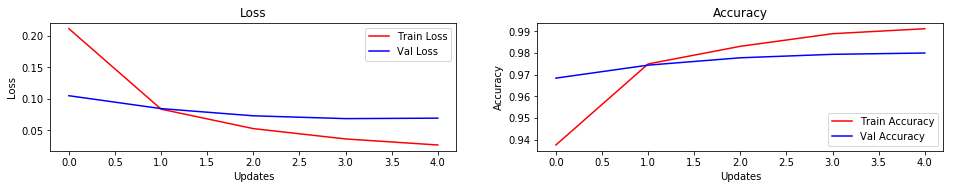

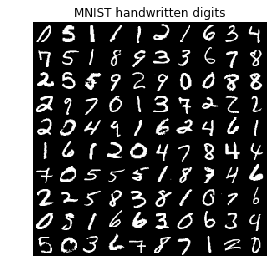

Network got 99 correct out of 100

Full output of predictions and targets is listed below

Prediction	 Target
0 		 0
5 		 5
1 		 1
1 		 1
1 		 1
2 		 2
1 		 1
6 		 6
3 		 3
4 		 4
7 		 7
5 		 5
1 		 1
8 		 8
9 		 9
3 		 3
3 		 3
6 		 6
7 		 7
8 		 8
2 		 2
5 		 5
5 		 5
9 		 9
2 		 2
9 		 9
0 		 0
0 		 0
8 		 8
8 		 8
2 		 2
9 		 9
7 		 7
0 		 0
1 		 1
3 		 3
7 		 7
2 		 2
2 		 2
2 		 2
2 		 2
0 		 0
4 		 4
9 		 9
1 		 1
6 		 6
2 		 2
4 		 4
6 		 6
1 		 1
1 		 1
6 		 6
1 		 1
2 		 2
0 		 0
4 		 4
7 		 7
8 		 8
4 		 4
4 		 4
7 		 7
0 		 0
5 		 5
5 		 5
5 		 5
1 		 1
8 		 8
7 		 7
4 		 4
6 		 6
2 		 2
2 		 2
5 		 5
8 		 8
3 		 3
8 		 8
1 		 1
0 		 0
7 		 7
6 		 6
0 		 0
3 		 5
1 		 1
6 		 6
6 		 6
3 		 3
0 		 0
6 		 6
3 		 3
4 		 4
5 		 5
0 		 0
3 		 3
6 		 6
7 		 7
8 		 8
7 		 7
1 		 1
2 		 2
0 		 0


In [63]:
### YOUR CODE HERE ###
# 1) Plot train and validation loss as a function of time
# 2) Plot train and validation accuracy as a function of time
# 3) Select some random validation images, visualize them, and examine the output of the network.
 ## Plotting
    
fig = plt.figure(figsize=(16,8))

epoch = np.arange(len(train_cost))
fig.add_subplot(325)
plt.title('Loss')
plt.plot(epoch, train_cost,'r', label='Train Loss')
plt.plot(epoch, val_cost,'b', label='Val Loss')
plt.legend()
plt.xlabel('Updates'), plt.ylabel('Loss')

fig.add_subplot(326)
plt.title('Accuracy')
plt.plot(epoch, train_acc,'r', label='Train Accuracy')
plt.plot(epoch, val_acc,'b', label='Val Accuracy')
plt.legend(loc=4)
plt.xlabel('Updates'), plt.ylabel('Accuracy')

idx = 0
canvas = np.zeros((28*img_to_show, img_to_show*28))
for i in range(img_to_show):
    for j in range(img_to_show):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_plot[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(4,4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')

plt.tight_layout()
plt.show()
count = 0
            
for i in range(len(y_plot)):
    if np.argmax(pred[i],-1) == np.argmax(y_plot[i],-1):
        count += 1

print('Network got {} correct out of {}'.format(*(count,img_to_show**2)))
print('\nFull output of predictions and targets is listed below\n')
print('Prediction\t Target')
for i in range(len(y_plot)):
    print(np.argmax(pred[i],-1),'\t\t',np.argmax(y_plot[i],-1))

# Exe 6) Complete chosen exercise from the book

I have chosen to do exercise given in the [book](http://neuralnetworksanddeeplearning.com/chap1.html#exercise_263792). The exercise is describes as follows:

An extreme version of gradient descent is to use a mini-batch size of just 1. That is, given a training input, x, we update our weights and biases according to the rules wk→w′k=wk−η∂Cx/∂wk and bl→b′l=bl−η∂Cx/∂bl. Then we choose another training input, and update the weights and biases again. And so on, repeatedly. This procedure is known as online, on-line, or incremental learning. In online learning, a neural network learns from just one training input at a time (just as human beings do). Name one advantage and one disadvantage of online learning, compared to stochastic gradient descent with a mini-batch size of, say, 20.

Solution:
One advantage of online learning (stochastic gradient descent) is that it converges much faster than mini-batch learning if the data contain some redundant information (which is usually the case). One other major reason to use this method is when it is very expensive to gather data and you therefore want to stop your training as soon as when your residual error is low enough.

One disadvantage is that online learning only takes one datapoint at a time and this makes training a lot slower since the optimizer can't use the higly optimized vectorized operations as when you use mini-batch learning.